# <b><u>False Positive Analysis and Cleaning<b><u>

This script offers a cleaning approach for falsly predicted crop pixels using a Random Forest Model which is trained on labeled training data.

### Load necessary packages

In [ ]:
# Standard library imports
import math
import os
import random
import shutil
import tempfile
from collections import defaultdict
from math import ceil

# Third-party imports
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal, gdalconst, osr
from rasterio.windows import Window
from scipy.stats import randint, uniform
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tqdm import tqdm

# **Section 1: Reclassify Rasters and create Sampling Points**

#### Step 1: Reclassify Predicted Fractional Map to low frequency and high frequency crop field 

In [ ]:
# Input merged Raster
input_path = r"C:\Users\phili\Thesis\tmp\ValidatedTiles\merged_fractional_map.tif"

In [ ]:
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)  # Create directory if missing
output_path = os.path.join(output_dir, "crop_frequency_reclass.tif")

In [ ]:
# Open input raster
src_ds = gdal.Open(input_path)
band = src_ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

# Create output raster with same dimensions and projection
driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(
    output_path, xsize, ysize, 1, gdal.GDT_Byte,
    options=['COMPRESS=LZW', 'BIGTIFF=YES']
)
dst_ds.SetProjection(src_ds.GetProjection())
dst_ds.SetGeoTransform(src_ds.GetGeoTransform())
out_band = dst_ds.GetRasterBand(1)
out_band.SetNoDataValue(0)

# Optimize block size based on raster structure
block_sizes = band.GetBlockSize()
x_block_size = block_sizes[0]
y_block_size = block_sizes[1]

# Process raster in blocks
for y in range(0, ysize, y_block_size):
    if y + y_block_size < ysize:
        rows = y_block_size
    else:
        rows = ysize - y
        
    for x in range(0, xsize, x_block_size):
        if x + x_block_size < xsize:
            cols = x_block_size
        else:
            cols = xsize - x

        # Read block
        data = band.ReadAsArray(x, y, cols, rows)
        
        # Reclassify using vectorized operations
        reclassified = np.full(data.shape, 0, dtype=np.uint8)  # Initialize with NoData
        mask_low = (data > 0) & (data <= 50)
        mask_high = data > 50
        reclassified[mask_low] = 1
        reclassified[mask_high] = 2
        
        # Write block
        out_band.WriteArray(reclassified, x, y)

# Finalize output
dst_ds.FlushCache()
dst_ds = None
src_ds = None

### Step 2: Reclassify Land Cover Crop Raster to 3 classes: 0 (all agree non-crop), 1 (1-2 agree it's crop), 2 (3-4 agree it's crop)

In [ ]:
input_path = r"C:\Users\phili\Thesis\tmp\no_crop_mask\non_crop_mask_final.tif"
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "landcover_crop_reclass.tif")

In [ ]:

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        dtype='uint8',
        nodata=255,
        compress='lzw'
    )
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Process raster in 512x512 blocks
        for ji, window in src.block_windows(1):
            data = src.read(1, window=window)
            
            # Initialize output with NoData (255)
            reclassified = np.full_like(data, 255, dtype='uint8')
            
            # Exact value reclassification
            reclassified[data == 100] = 0    # Class 0
            reclassified[data == 75] = 1     # Class 1
            reclassified[data == 50] = 1     # Class 1
            reclassified[data == 25] = 2     # Class 2
            reclassified[data == 0] = 2      # Class 2
            
            dst.write(reclassified, window=window, indexes=1)

### Step 3: Intersect both Maps

In [ ]:
# Input paths
crop_freq_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/crop_frequency_reclass.tif"
lc_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/landcover_crop_reclass.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"

In [ ]:
# Configure GDAL for massive datasets
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'YES')
gdal.SetConfigOption('CHECK_DISK_FREE_SPACE', 'NO')
gdal.SetConfigOption('GDAL_NUM_THREADS', 'ALL_CPUS')

# Open datasets
crop_ds = gdal.OpenEx(crop_freq_path, gdalconst.GA_ReadOnly)
lc_ds = gdal.OpenEx(lc_path, gdalconst.GA_ReadOnly)

# Get crop raster parameters
crop_gt = crop_ds.GetGeoTransform()
crop_proj = crop_ds.GetProjection()
cols = crop_ds.RasterXSize
rows = crop_ds.RasterYSize

# Create output with compression
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(
    output_path, cols, rows, 1, gdalconst.GDT_Byte,
    options=['COMPRESS=LZW', 'PREDICTOR=2', 'TILED=YES', 'BIGTIFF=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256']
)
output_ds.SetGeoTransform(crop_gt)
output_ds.SetProjection(crop_proj)
output_band = output_ds.GetRasterBand(1)
output_band.SetNoDataValue(0)

# Process in blocks with exact dimension matching
block_size = 1024  # Keep this as-is
total_blocks = ((rows + block_size - 1) // block_size) * ((cols + block_size - 1) // block_size)

with tqdm(total=total_blocks, desc="Processing", unit="block") as pbar:
    for y_offset in range(0, rows, block_size):
        y_height = min(block_size, rows - y_offset)
        
        for x_offset in range(0, cols, block_size):
            x_width = min(block_size, cols - x_offset)
            
            # Read crop frequency block
            crop_block = crop_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_width, y_height)
            
            # Calculate exact bounds for this block
            x_min = crop_gt[0] + x_offset * crop_gt[1]
            y_max = crop_gt[3] + y_offset * crop_gt[5]
            x_max = x_min + x_width * crop_gt[1]
            y_min = y_max + y_height * crop_gt[5]
            
            # Warp LC data with EXPLICIT output dimensions
            lc_block = gdal.Warp('', lc_path,
                format='MEM',
                outputBounds=(x_min, y_min, x_max, y_max),
                xRes=crop_gt[1],
                yRes=abs(crop_gt[5]),
                width=x_width,  # Force exact dimension match
                height=y_height,
                resampleAlg=gdalconst.GRA_NearestNeighbour,
                outputType=gdalconst.GDT_Byte
            ).ReadAsArray()
            
            # Verify block shapes match
            if crop_block.shape != lc_block.shape:
                raise ValueError(f"Block shape mismatch at ({x_offset},{y_offset}): {crop_block.shape} vs {lc_block.shape}")
            
            # Calculate output classes
            output_data = np.zeros_like(crop_block, dtype=np.uint8)
            
            # Class mapping with explicit casting
            output_data = output_data.astype(np.uint8)
            output_data[(crop_block == 1) & (lc_block == 0)] = 1
            output_data[(crop_block == 1) & (lc_block == 1)] = 2
            output_data[(crop_block == 1) & (lc_block == 2)] = 3
            output_data[(crop_block == 2) & (lc_block == 0)] = 4
            output_data[(crop_block == 2) & (lc_block == 1)] = 5
            output_data[(crop_block == 2) & (lc_block == 2)] = 6
            
            # Write output with exact window
            output_band.WriteArray(output_data, xoff=x_offset, yoff=y_offset)
            pbar.update(1)

# Cleanup
output_ds = None
crop_ds = None
lc_ds = None

print(f"✅ Success! Output created at: {output_path}")


### Step 4: Sample Points within each class

#### 4.1: Count Pixels per Class

In [ ]:
raster_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg"

In [ ]:
def count_classes_blocked(raster_path):
    """Count pixels per class with progress tracking"""
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    xsize, ysize = band.XSize, band.YSize
    block_x, block_y = band.GetBlockSize()
    
    counts = {}
    total_blocks = ((ysize + block_y - 1) // block_y) * ((xsize + block_x - 1) // block_x)
    
    with tqdm(total=total_blocks, desc="Counting classes", unit="block") as pbar:
        for y in range(0, ysize, block_y):
            y_height = min(block_y, ysize - y)
            for x in range(0, xsize, block_x):
                x_width = min(block_x, xsize - x)
                data = band.ReadAsArray(x, y, x_width, y_height)
                
                if nodata is not None:
                    data = data[data != nodata]
                
                unique, counts_chunk = np.unique(data, return_counts=True)
                for val, cnt in zip(unique, counts_chunk):
                    if val == 0:  # Skip NoData
                        continue
                    counts[val] = counts.get(val, 0) + int(cnt)
                
                pbar.update(1)
    
    ds = None
    return counts

In [ ]:
# Count classes
class_counts = count_classes_blocked(intersect_raster)
print("Pixel counts per class:", class_counts)

In [ ]:
# Use pre-calculated pixel counts
pixel_counts = {3: 431784025, 1: 15857486835, 4: 6093596578, 
                5: 3622280348, 2: 3342416411, 6: 1171686069}
total_pixels = sum(pixel_counts.values())

# Calculate proportional samples without iterating the raster
samples_per_class = {
    cls: max(1, ceil((count / total_pixels) * 300)) 
    for cls, count in pixel_counts.items()
}


In [3]:
def calculate_samples(pixel_counts, total_samples=300):
    total = sum(pixel_counts.values())
    samples = {
        cls: max(1, int(round((count / total) * total_samples)))
        for cls, count in pixel_counts.items()
    }
    # Adjust to exact total
    current_total = sum(samples.values())
    if current_total != total_samples:
        adjust_cls = max(samples, key=lambda k: samples[k])
        samples[adjust_cls] += (total_samples - current_total)
    return samples

def random_pixel_sampling(raster_path, samples_per_class, max_attempts=1000000, min_distance_deg=0.001):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        classes_needed = samples_per_class.copy()
        found_points = defaultdict(list)
        found_coords = []

        total_needed = sum(classes_needed.values())
        attempts = 0

        # For progress bar
        pbar = tqdm(total=total_needed, desc="Random sampling", unit="pt")

        while sum(classes_needed.values()) > 0 and attempts < max_attempts:
            # Random pixel
            row = random.randint(0, height - 1)
            col = random.randint(0, width - 1)
            val = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))[0, 0]

            # Only sample if this class still needs points
            if val in classes_needed and classes_needed[val] > 0:
                # Convert to lon/lat
                lon, lat = src.xy(row, col)
                pt = Point(lon, lat)

                # Check minimum distance constraint
                too_close = False
                for other_pt in found_coords:
                    if pt.distance(other_pt) < min_distance_deg:
                        too_close = True
                        break
                if too_close:
                    attempts += 1
                    continue

                found_points[val].append(pt)
                found_coords.append(pt)
                classes_needed[val] -= 1
                pbar.update(1)
            attempts += 1

        pbar.close()

        # Flatten to GeoDataFrame
        data = []
        for cls, pts in found_points.items():
            for pt in pts:
                data.append({'class': cls, 'geometry': pt})
        gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')

        if sum(classes_needed.values()) > 0:
            print(f"Warning: Could not find all samples. Missing: {classes_needed}")

        return gdf



In [4]:

def main():
    samples = calculate_samples(pixel_counts)
    print("Samples per class:", samples)
    gdf = random_pixel_sampling(raster_path, samples, min_distance_deg=0.001)  # ~100m at equator
    gdf.to_file(output_path, driver="GPKG")
    print(f"Saved {len(gdf)} points to {output_path}")

if __name__ == "__main__":
    main()

Samples per class: {3: 4, 1: 155, 4: 60, 5: 36, 2: 33, 6: 12}


Random sampling:   0%|          | 0/300 [00:00<?, ?pt/s]

Saved 300 points to /home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg


<br>

---

<br>

# **Section 2: Sampling in Google Earth Engine**

### Connect to GEE

In [2]:
ee.Authenticate()
# Initialize the Earth Engine API and Project
ee.Initialize(project='angola-thesis')

In [3]:
# Load sampling points 
points = ee.FeatureCollection('projects/angola-thesis/assets/sampling_points_labeled')

# Load Angola boundary 
angola = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

# Check if assets exist
print(points.size().getInfo())  # Should return 300
print(angola.size().getInfo())  # Should return 1 


300
1


## Load Predictor Variables

#### DEM

In [4]:
# ALOS DSM (12m)
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2') \
         .mosaic() \
         .select('DSM') \
         .clip(angola)

# Terrain derivatives
slope = ee.Terrain.slope(alos).rename('slope')
tpi = alos.subtract(alos.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=ee.Kernel.square(3)
)).rename('tpi')


#### Soil Texture

In [5]:
# Soil Texture (250m)
soil = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02') \
    .select('b0').rename('soil_texture')

# ESA WorldCover (10m)
landcover = ee.ImageCollection('ESA/WorldCover/v200') \
    .filterDate('2020-01-01', '2024-12-31') \
    .first()


#### Evapotranspiration + Precipitation

In [6]:
# MODIS Evapotranspiration (500m)
et = ee.ImageCollection('MODIS/061/MOD16A2') \
    .filterDate('2018-01-01', '2023-12-31') \
    .select('ET') \
    .mean() \
    .multiply(0.1)  # Scale factor
# Ends 2023

# CHIRPS Precipitation (5km)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2018-01-01', '2024-12-31') \
    .sum()

# Compute Aridity Index (Precipitation/ET)
aridity = precip.divide(et).rename('aridity')


#### MODIS Temporal Vegetation Features

In [7]:
# MODIS Temporal Features (Phenology)
modis_temp = ee.ImageCollection("MODIS/061/MCD12Q2") \
    .filterDate('2018-01-01', '2023-12-31') \
    .select(['Greenup_1', 'Peak_1', 'QA_Overall_1']) \
    .map(lambda img: img.updateMask(img.select('QA_Overall_1').eq(0))) \
    .mean() \
    .resample('bilinear').reproject(crs='EPSG:4326', scale=500)

In [8]:
def create_modis_ndvi():
    modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterBounds(angola) \
        .filterDate('2018-01-01', '2024-12-31') \
        .select('NDVI')
    ndvi_mean = modis.mean().multiply(0.0001).rename('modis_ndvi_mean')
    ndvi_std = modis.reduce(ee.Reducer.stdDev()).multiply(0.0001).rename('modis_ndvi_std')
    return ndvi_mean.addBands(ndvi_std)
modis_ndvi = create_modis_ndvi()

#### S2 NDVI

In [9]:
def create_lightweight_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-01-01', '2024-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024')
    return ndvi

annual_ndvi_2024 = create_lightweight_ndvi()


In [10]:
def create_seasonal_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-04-01', '2024-09-30') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024_season')
    return ndvi

seasonal_ndvi_2024 = create_seasonal_ndvi()


In [11]:
# Combine into single NDVI image
ndvi_features = annual_ndvi_2024 \
    .addBands(seasonal_ndvi_2024) \
    .addBands(modis_ndvi)

### Stack all Layers

In [12]:
def stack_all_layers():
    # High-res (10m): Sentinel NDVI + terrain
    high_res = ndvi_features.select(['ndvi_2024', 'ndvi_2024_season']) \
        .addBands(alos.rename('elevation')) \
        .addBands(slope) \
        .addBands(tpi) \
        .addBands(landcover.rename('landcover'))
    
    # Med-res (250m): MODIS NDVI + soil + et
    med_res = ndvi_features.select(['modis_ndvi_mean', 'modis_ndvi_std']) \
        .addBands(soil) \
        .addBands(et) \
        .addBands(aridity)
    
    # Low-res (5km): precip
    low_res = precip.rename('precip')
    
    return high_res.addBands(med_res).addBands(low_res)

full_stack = stack_all_layers()
# Get band names (instant metadata call)
print(full_stack.bandNames().getInfo()) 

### Extract values based on sampling points

In [14]:
def optimized_extraction(points):
    # High-res features (10m) - Sentinel NDVI + Terrain
    high_res_data = full_stack.select([
        'ndvi_2024', 'ndvi_2024_season',  # Sentinel-2 NDVI
        'elevation', 'slope', 'tpi', 'landcover'  # ALOS derivatives
    ]).reduceRegions(
        collection=points,
        reducer=ee.Reducer.first(),
        scale=10  # Matches Sentinel-2/ALOS resolution
    )
    
    # Medium-res features (250m) - MODIS NDVI + Soil + ET
    med_res_data = full_stack.select([
        'modis_ndvi_mean', 'modis_ndvi_std',  # MODIS trends
        'soil_texture', 'ET', 'aridity'  # Soil and water features
    ]).reduceRegions(
        collection=high_res_data,
        reducer=ee.Reducer.first(),
        scale=250  # MODIS/Soil native resolution
    )

    # Low-res precip (5000m) - CHIRPS
    final_data = full_stack.select(['precip']) \
        .reduceRegions(
            collection=med_res_data,
            reducer=ee.Reducer.first().setOutputs(['precip']), # When reducing multiple bands, EE preserves original names. For single-band reductions, it uses 'first'.
            scale=5000  # CHIRPS native resolution
        )

    return final_data

training_data = optimized_extraction(points)

In [15]:
# Export & Clean DataFrame
df = geemap.ee_to_df(training_data).dropna()

# Remove system columns
df = df[df.columns[~df.columns.str.startswith('system:')]]

# Verify columns
print(df.columns.tolist())

['ET', 'aridity', 'class', 'elevation', 'fid', 'field', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'ndvi_2024', 'ndvi_2024_season', 'precip', 'slope', 'soil_texture', 'tpi']


In [16]:
print(len(df))


260


In [17]:
df.head()

,ET,aridity,class,elevation,fid,field,landcover,modis_ndvi_mean,modis_ndvi_std,ndvi_2024,ndvi_2024_season,precip,slope,soil_texture,tpi
0,17.493431,394.335141,1,1539,1,0,30,0.617660,0.127298,0.491960,0.408429,6894.252860,0.088469,9,0.551020
1,18.516788,465.413812,1,1082,2,0,30,0.600931,0.127695,0.606785,0.600071,8617.969045,0.010041,6,-0.163265
2,10.281022,174.947044,1,195,3,0,20,0.200982,0.039603,0.168083,0.170018,1798.634391,0.369697,6,-2.346939
3,11.994891,597.636324,1,1508,4,0,20,0.494647,0.101407,0.345192,0.335322,7076.946386,0.275511,9,0.755102
4,14.185401,426.514446,1,1228,6,0,30,0.471712,0.150322,0.286742,0.284632,5964.000822,0.031967,9,-0.183673


### Build the RF Model

In [25]:
# X: all predictor columns (drop identifiers and label)
x = df.drop(['fid', 'field'], axis=1)

# y: label (1 = field, 0 = non-field)
y = df['field']

In [26]:
# Impute missing values with column medians
imputer = SimpleImputer(strategy='median')
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3,       # 30% for testing
    stratify=y,          # preserve class balance
    random_state=42
)


In [32]:
rf = RandomForestClassifier(
    n_estimators=394,        # Number of trees
    max_depth=21,            # Limit tree depth to prevent overfitting
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    max_features='log2',
    min_samples_split=13,
)
rf.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=21,
                       max_features='log2', min_samples_split=13,
                       n_estimators=394, random_state=42)

Accuracy: 0.82
              precision    recall  f1-score   support

   Non-field       0.85      0.88      0.87        51
       Field       0.76      0.70      0.73        27

    accuracy                           0.82        78
   macro avg       0.80      0.79      0.80        78
weighted avg       0.82      0.82      0.82        78



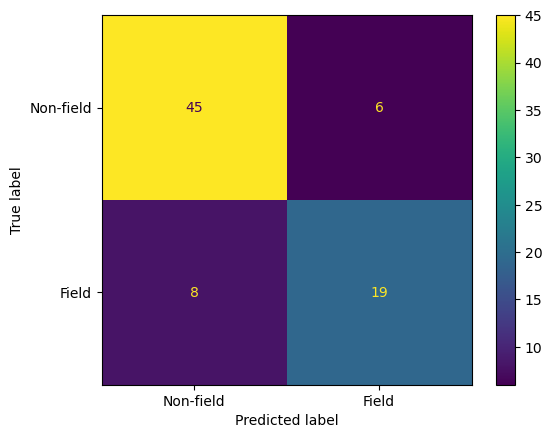

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=['Non-field', 'Field']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-field', 'Field']).plot()


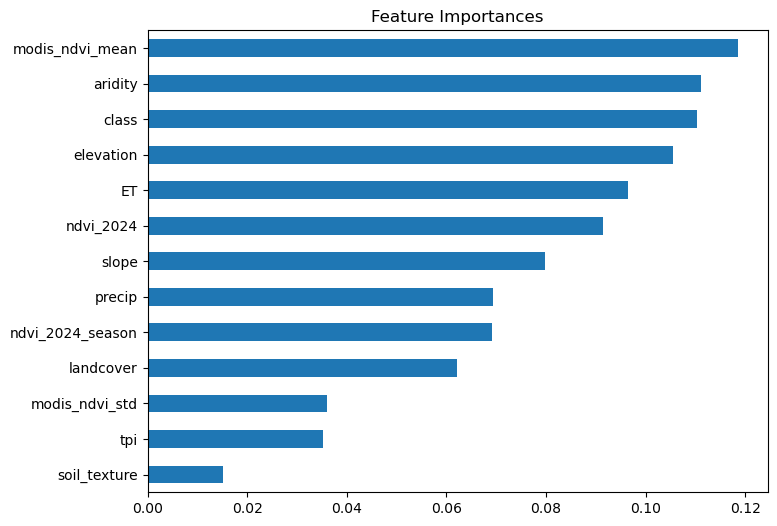

In [34]:
importances = pd.Series(rf.feature_importances_, index=x.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6), title='Feature Importances')
plt.show()


#### Hyperparameter Tuning

In [31]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Increased from 10
    cv=5,
    scoring='roc_auc',
    random_state=42
)
rand_search.fit(x_train, y_train)

print('Best hyperparameters:', rand_search.best_params_)
best_rf = rand_search.best_estimator_

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 13, 'n_estimators': 394}


<br>

---

<br>

# **Section 3: Exctract Predictors for Entire Study Area based on Tiles**

In [40]:
# Load Angola Tiles
tiles = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_crop')

# Check if assets exist
print(tiles.size().getInfo()) 

25128


In [50]:
# List your band names
continuous_bands = ['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi',
                    'modis_ndvi_mean', 'modis_ndvi_std', 'ET', 'aridity', 'precip']
categorical_bands = ['landcover', 'soil_texture']  # Add any other categorical bands

# Resample continuous bands
resampled_bands = []
for band in continuous_bands:
    b = full_stack.select(band).resample('bilinear').reproject('EPSG:32733', None, 10)
    resampled_bands.append(b)

# For categorical bands, just reproject (default is nearest neighbor)
for band in categorical_bands:
    b = full_stack.select(band).reproject('EPSG:32733', None, 10)
    resampled_bands.append(b)

# Stack all bands together
resampled_stack = ee.Image.cat(resampled_bands)
print("Resampled stack bands:", resampled_stack.bandNames().getInfo())


Resampled stack bands: ['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi', 'modis_ndvi_mean', 'modis_ndvi_std', 'ET', 'aridity', 'precip', 'landcover', 'soil_texture']


In [51]:
def create_processing_grid():
    # Create 10km grid cells aligned with 10m resolution
    return ee.FeatureCollection(
        ee.Image.pixelLonLat()
        .reproject('EPSG:32733', scale=10000)
        .reduceToVectors(
            reducer=ee.Reducer.countEvery(),
            geometry=tiles.geometry().bounds(),
            scale=10000,
            geometryType='rectangle',
            eightConnected=False,
            maxPixels=1e13,
            tileScale=16
        )
        .map(lambda f: f.buffer(5000).bounds())  # 50km buffer for edge overlap
    )

processing_grid = create_processing_grid()
print(f"Processing grid cells: {processing_grid.size().getInfo()}")


EEException: Image.reduceToVectors: Need 1+0 bands for Reducer.countEvery, image has 2.

In [44]:
'''
import geopandas as gpd

# Path to your tile GeoJSON
tile_path = r"/home/airg/PSteinhilber/projects/angola/grids/angola_tiles_crop_filtered.geojson"

# Load tiles as a GeoDataFrame
tiles_gdf = gpd.read_file(tile_path)
print(f"Loaded {len(tiles_gdf)} tiles")
tiles_gdf.head()
'''

Loaded 25128 tiles


,tile,tile_col,tile_row,geometry
0,776769,608.0,838.0,"POLYGON ((12.85453 -4.41448, 12.91348 -4.41448..."
1,776789,608.0,839.0,"POLYGON ((12.85453 -4.46448, 12.91348 -4.46448..."
2,787660,599.0,842.0,"POLYGON ((12.40452 -4.61447, 12.46348 -4.61447..."
3,787680,599.0,843.0,"POLYGON ((12.40452 -4.66448, 12.46348 -4.66448..."
4,787716,595.0,845.0,"POLYGON ((12.20453 -4.76448, 12.26347 -4.76448..."


In [45]:
'''
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Load your tiles
tiles_gdf = gpd.read_file(tile_path)

# Prepare a list to hold the new (non-overlapping) geometries
non_overlapping_geoms = []
used_union = None  # Will hold the union of all previous tiles

for idx, row in tiles_gdf.iterrows():
    geom = row.geometry
    # Subtract the union of all previous tiles from the current tile
    if used_union is not None:
        geom = geom.difference(used_union)
    # Only keep non-empty geometries
    if not geom.is_empty:
        non_overlapping_geoms.append(geom)
        # Update the union with the newly added geometry
        if used_union is None:
            used_union = geom
        else:
            used_union = unary_union([used_union, geom])

# Create a new GeoDataFrame with the non-overlapping geometries
result_gdf = tiles_gdf.copy()
result_gdf['geometry'] = non_overlapping_geoms

# Remove empty geometries if any
result_gdf = result_gdf[~result_gdf.is_empty]

result_gdf = result_gdf.reset_index(drop=True)
print(f"Created {len(result_gdf)} non-overlapping tiles")
result_gdf.head()
'''

KeyboardInterrupt: 